In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from random import sample

In [2]:
df = pd.read_csv("trajectory.csv")
df.columns = ["time", "vehicle_id", "edge", "lane", "x", "y","toremove"]
del df['toremove']
df.head() # df now holds the data

,time,vehicle_id,edge,lane,x,y
0,0,flow_1.0,gneE1,gneE1_1,5.1,-14.8
1,0,flow_10.0,gneE10,gneE10_2,5.1,-101.6
2,0,flow_11.0,gneE11,gneE11_0,5.1,-118.0
3,0,flow_12.0,gneE12,gneE12_2,5.1,-121.6
4,0,flow_13.0,gneE13,gneE13_1,5.1,-134.8


In [4]:
# Obtain all the traces of a particular edge, here gneE0 is chosen
# df_edge = df[(df['vehicle_id'].isin(selected_vehicle_ids)) & (df['edge'] == 'gneE0')]
# df_edge = df[df['edge'] == 'gneE0'] # for non-parellel edges
df_edge = df  # scam_wide, run this
vehicle_ids_on_edge = df_edge['vehicle_id'].unique().tolist()
selected_vehicle_ids = sample(vehicle_ids_on_edge, 200) # get 100 vehicle traces
df_mini = df_edge[df_edge['vehicle_id'].isin(selected_vehicle_ids)]
df_mini.head()

,time,vehicle_id,edge,lane,x,y
5,0,flow_2.0,gneE2,gneE2_1,5.100000,-24.8
7,0,flow_4.0,gneE4,gneE4_1,5.100000,-44.8
8,0,flow_5.0,gneE5,gneE5_1,5.100000,-54.8
13,1,flow_0.0,gneE0,gneE0_2,6.117507,-1.6
19,1,flow_2.0,gneE2,gneE2_1,6.113556,-24.8


In [5]:
import numpy as np

Max length of trajectory x: 430
Max length of trajectory y: 430


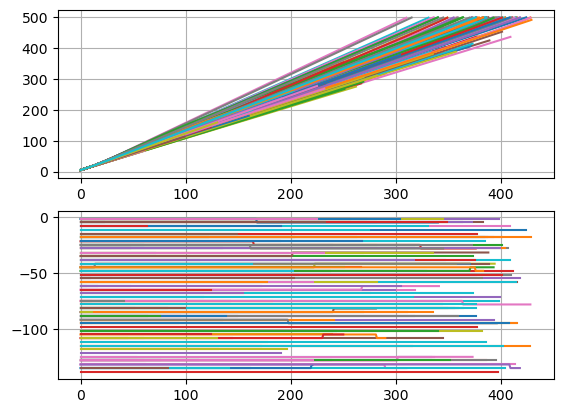

In [6]:
fig = plt.figure()
plt_x = fig.add_subplot(2,1,1)
plt_x.grid(True)
plt_y = fig.add_subplot(2,1,2)
plt_y.grid(True)
max_length_y = 0
max_length_x = 0

x_mat = np.zeros((len(selected_vehicle_ids)),)
x_mat = np.zeros((len(selected_vehicle_ids)),)

for veh_id in selected_vehicle_ids:
    df_of_veh = df_mini[df_mini['vehicle_id'] == veh_id]
    t_vec = df_of_veh['time'].to_numpy()
    t_vec = t_vec - t_vec[0]
    x_vec = df_of_veh['x'].to_numpy()
    y_vec = df_of_veh['y'].to_numpy()
    if x_vec.shape[0] > max_length_x:
        max_length_x = x_vec.shape[0]
    if y_vec.shape[0] > max_length_y:
        max_length_y = y_vec.shape[0]
    plt_x.plot(t_vec, x_vec)
    plt_y.plot(t_vec, y_vec)

print('Max length of trajectory x: {:d}'.format(max_length_x))
print('Max length of trajectory y: {:d}'.format(max_length_y))

In [7]:
z_mat = np.zeros((len(selected_vehicle_ids), max_length_x))
t_mat = None
z_last = np.zeros((len(selected_vehicle_ids,))) # last value of z_vector for each vehicle, for extrapolation!
z_rate = np.zeros((len(selected_vehicle_ids,))) # the speed to linearly extrapolate
z_len = np.zeros((len(selected_vehicle_ids,))) # the speed to linearly extrapolate

for i, veh_id in enumerate(selected_vehicle_ids):
    df_of_veh = df_mini[df_mini['vehicle_id'] == veh_id]
    if t_mat is None:
        t_mat = df_of_veh['time'].to_numpy()
    # t_vec = t_vec - t_vec[0]
    x_vec = df_of_veh['x'].to_numpy()
    y_vec = df_of_veh['y'].to_numpy()
    z_vec = x_vec
    z_len[i] = z_vec.shape[0]
    z_mat[i,:z_vec.shape[0]] = z_vec  
    z_last[i] = z_vec[-1]
    z_rate[i] = (z_vec[-1] - z_vec[-4])/3.

In [8]:
length_desired = 400 # all resulting trajectories will have this length
z_cutoff = 300 # do not consider trajectories shorter than this
z_mat_good = np.zeros((z_mat.shape[0], length_desired))
j=0
for i in range(z_mat.shape[0]):
    if z_len[i] < z_cutoff:
        print('Skipping trajectory {} due to being too short!'.format(i))
        continue
    if z_len[i] > length_desired:
        # just trim this trajectory to length desired
        z_mat_good[j,:] = z_mat[i,:length_desired]
        j+=1
        continue 
    if z_len[i] < length_desired:
        # short (but still good enough to be linearly extrapolated)
        zv = z_mat[i,:int(z_len[i])]
        z_mat_good[j,:zv.shape[0]] = zv
        z_mat_good[j, zv.shape[0]:] = z_last[i] + z_rate[i] * np.arange(1, length_desired - zv.shape[0] + 1)
        j+=1

Skipping trajectory 3 due to being too short!
Skipping trajectory 4 due to being too short!
Skipping trajectory 5 due to being too short!
Skipping trajectory 7 due to being too short!
Skipping trajectory 11 due to being too short!
Skipping trajectory 12 due to being too short!
Skipping trajectory 13 due to being too short!
Skipping trajectory 16 due to being too short!
Skipping trajectory 17 due to being too short!
Skipping trajectory 18 due to being too short!
Skipping trajectory 20 due to being too short!
Skipping trajectory 21 due to being too short!
Skipping trajectory 28 due to being too short!
Skipping trajectory 30 due to being too short!
Skipping trajectory 31 due to being too short!
Skipping trajectory 32 due to being too short!
Skipping trajectory 34 due to being too short!
Skipping trajectory 39 due to being too short!
Skipping trajectory 41 due to being too short!
Skipping trajectory 42 due to being too short!
Skipping trajectory 46 due to being too short!
Skipping trajecto

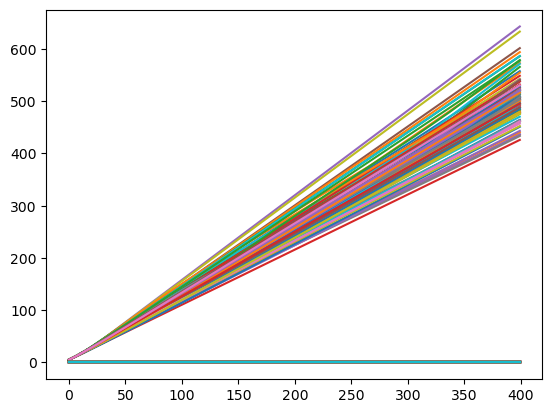

In [9]:
for i in range(z_mat_good.shape[0]):
    plt.plot(z_mat_good[i,:])

In [10]:
# Export the data to CSV to be processed with unsupervised segmentation in R
df_mini[['vehicle_id','time','x','y']].to_csv('edge_trajectories.csv')

Write to pyo file for use with spherical_codes.ipynb

In [11]:
import pickle

with open('trajectories.pyo', 'wb') as f:
    obj2dump = {'y_vec': z_mat_good, 'x_vec': z_mat_good, 't_vec': t_mat}
    pickle.dump(obj2dump, f)

print('Completed writing pyo file')

Completed writing pyo file
